In [1]:
import pandas as pd
import numpy as np
import os 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '../../../openAi/TS_analysis_TOPIC9/'))

#### TODO: Import CDlib, use and compare CD algorithms.

In [3]:
from pyts_utils import descriptive_tools
from pyts_utils import proximity_tools
from cdlib import algorithms, ensemble,evaluation
from cdlib import viz

In [4]:
af_ex_pca = pd.read_csv('af_ex_pca.csv',index_col=0)

In [5]:
pivot_afex=af_ex_pca.pivot_table(values='af_ex_pca',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')
pivot_afex=pivot_afex.dropna(axis=1,thresh=15)

### Binnacle of distances, network construction, algorithms, parameters, and observation of results.

1. The first combination that shows some interesting structure is using pearson correlation as similarity and turned dissimilarity using 1-abs(r). Then an $\epsilon$-NN network is constructed setting $\epsilon = 0.55$ to connect pairs of time nodes with less than $\epsilon$ distance. We filled NA using zeros. (.fillna(0)). The graph G is constructed using networkx. Then we applied greedy_modularity and found 3 communities. The interesting observation is that these three communities, their country-average time series which ended up with three time series, separate the countries as antifragile over time, and two more or less robust over time. One potential PROBLEM!!! the share of countries per community is  0:47.8%, 1:30.18%, and 2:22%. Therefore, it might be that group 2 is antifragile on average because it has less number of countries. Nonetheless, fortunately considering all the time series and just labeling their communities (i.e., not averaging), the observation that community 2 is antifragily still holds!! :). To make sure that this is result is independent of the share of countries among the communities found, one option could be to randomly generate labels of three catergorical classes to simulate the three communities found and distribute the labels among countries such that we end up with the same share of countries among communities as the CD algorithm computed. In this way, if we repeat the process several times, we could statistically conclude that the community pattern found can not be explained by random labels. 

In [42]:
afex_imputed = pivot_afex.interpolate(limit_direction='both',method='spline',order=1)

In [44]:
Distance_matrix = 1 - abs(afex_imputed.corr())

In [139]:
## ϵ-NN network construction
ϵ = 0.9
epsilon_NN = Distance_matrix[Distance_matrix < ϵ]
epsilon_NN = epsilon_NN.fillna(0)

In [140]:
G = nx.Graph()
for country1,series in epsilon_NN.iteritems():
    for country2,proximity in series.iteritems():
        if not np.equal(proximity,0):  
            G.add_edge(country1,country2)

In [141]:
#Greedy_modul
# communities = algorithms.greedy_modularity(G)

# louvain
communities = algorithms.louvain(G)

In [142]:
len(communities.communities)

4

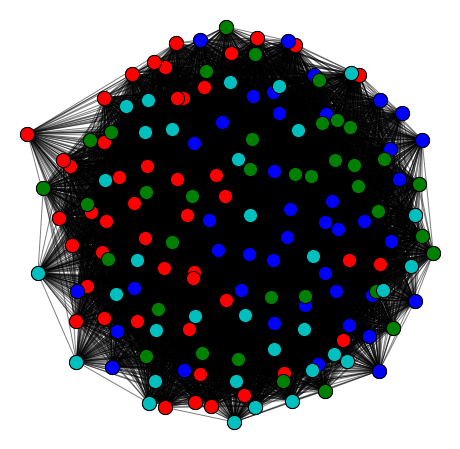

In [143]:
viz.plot_network_clusters(G,communities)

In [144]:
indices = [ index for index,group in enumerate(communities.communities) for count in group ]
countries = [c for g in communities.communities for c in g]

In [145]:
df_communities = pd.DataFrame(data=np.c_[countries,indices],columns=['country','labels'])

In [146]:
df_communities.to_excel('cluster.xlsx')

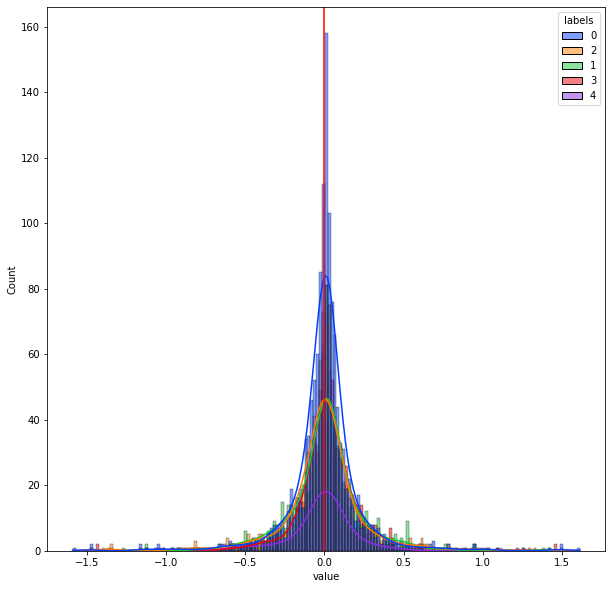

In [113]:
plt.figure(figsize=(10,10))  
sns.histplot(x='value',data=pivot_afex.T.merge(df_communities,on='country').melt(id_vars=['country','labels']),hue='labels',kde=True,palette='bright')
plt.axvline(0,c='red')

In [147]:
pivot_afex.T.merge(df_communities,on='country').groupby('labels').count()['country']/pivot_afex.shape[1] * 100 # Number of countries per community

labels
0    29.559748
1    26.415094
2    23.270440
3    20.754717
Name: country, dtype: float64

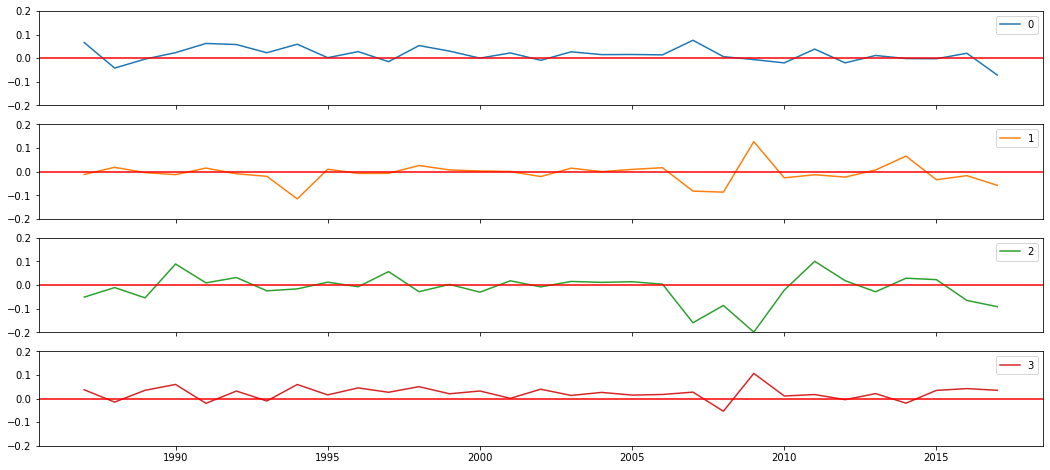

In [154]:
axes=pivot_afex.T.merge(df_communities,on='country').groupby('labels').mean().T.plot(ylim=(-.2,.2),figsize=(18,8),subplots=True)
for ax in axes:
    ax.axhline(0,c='red')

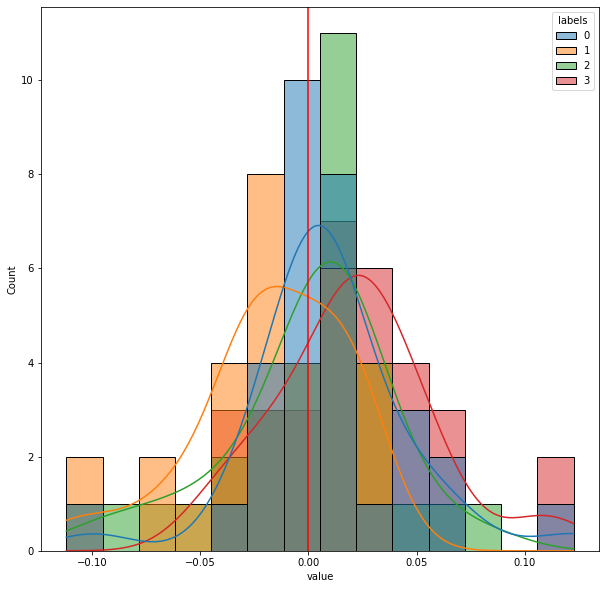

In [130]:
plt.figure(figsize=(10,10))
sns.histplot(x='value',data=pivot_afex.T.merge(df_communities,on='country').groupby('labels').mean().T.melt(),hue='labels',kde=True)
plt.axvline(0,c='red')

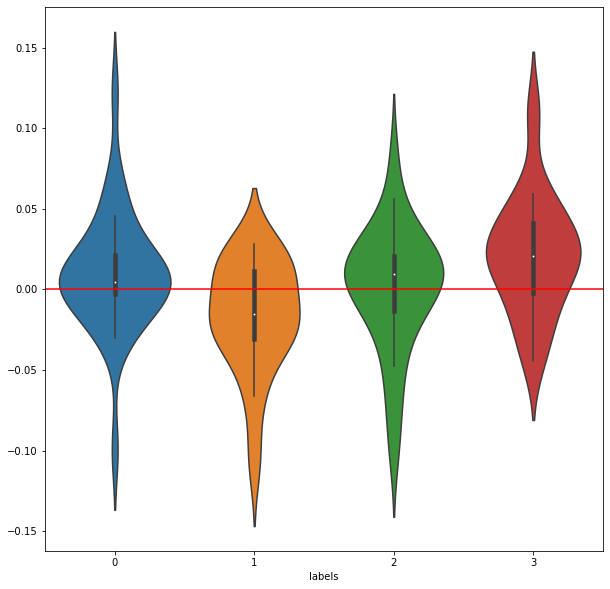

In [131]:
plt.figure(figsize=(10,10))
sns.violinplot(data=pivot_afex.T.merge(df_communities,on='country').groupby('labels').mean().T)
plt.axhline(0,c='red')